In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import tqdm
import faiss
  
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

import pysolr

2023-04-13 01:31:55.625640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
solr = pysolr.Solr('http://localhost:8983/solr/NasaImageData', timeout=100)
results = solr.search(q='*:*', rows=20000)
print(len(results))


11884


In [4]:
import urllib.request
import re
import time
print(type(results))
results_list = []
for result in results:
    title = result['title'][0]
    title = re.sub(r'[^a-zA-Z0-9]', '_', title)
    title = title.strip('_').strip('.')
    title = title[:30]
    image_url = result['link'][0]
    image_url = image_url.replace(" ", "%20")
    result = [title, image_url]
    results_list.append(result)
print(len(results_list))

<class 'pysolr.Results'>
11884


In [5]:

num = 0
for i in range (num,len(results_list)):
    
    try:
    # Get the title and image link from the document
        title = results_list[i][0]
        image_url = results_list[i][1]
    
    # Download the image and save it with the title as the file name
        image_data = urllib.request.urlopen(image_url).read()
        with open(f"./SpaceImage/{title}.jpg", 'wb') as f:
            f.write(image_data)
        time.sleep(0.5)
        if (i%100 == 0):
            print(i)
    except:
        print(image_url)
        print(i)
        break

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800


In [3]:
image_list =  glob.glob('SpaceImage/*.jpg')
print(len(image_list))

class FeatureExtract_VGG16:
    def __init__(self):

        self.vgg16 = VGG16(weights='imagenet', include_top=False,pooling='avg',input_shape=(224,224,3))
    
    # function to extract features from images
    def extractFeat(self,fileName):
        img = image.load_img(fileName, target_size=(224, 224))
        img_array = image.img_to_array(img)
        # expand_dims for image
        img_array = np.expand_dims(img_array, axis=0)
        # preprocess the image
        img_array = preprocess_input(img_array)
        # extract features of the image using vgg16
        feat = self.vgg16.predict(img_array)
        # L2
        feat = feat[0] / np.linalg.norm(feat[0])

        return feat

6896


In [5]:
feature_extract_vgg16 = FeatureExtract_VGG16()
# feat_list_vgg16 = []

name_list_vgg = []
i = 0
for img_file in image_list:
    # 提取特征
    feat_vec = feature_extract_vgg16.extractFeat(img_file)
    # 将特征加入列表
    feat_list_vgg16.append(feat_vec)
    # 解析文件
    name = img_file.split(os.sep)[-1].split('.')[0]
    # 将文件名加入列表
    name_list_vgg.append(name)
    i += 1
    if i % 100 == 0:
        print(i)

2023-04-13 01:33:02.900358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800


In [6]:
print(len(feat_list_vgg16))

NameError: name 'feat_list_vgg16' is not defined

In [4]:

name_list_vgg = np.array(name_list_vgg)
np.save('./image_feature/name_list_vgg.npy',name_list_vgg)

index_vgg = faiss.IndexFlatL2(512)
feat_list_vgg16 = np.array(feat_list_vgg16)
index_vgg.add(feat_list_vgg16)
faiss.write_index(index_vgg, './image_feature/voc_vgg.index')


NameError: name 'name_list_vgg' is not defined

In [8]:
index_vgg.ntotal

6896

In [7]:
index_vgg = faiss.read_index('./image_feature/voc_vgg.index')
name_list_vgg = np.load('./image_feature/name_list_vgg.npy')

1/1 [==============================] - 1s 585ms/step


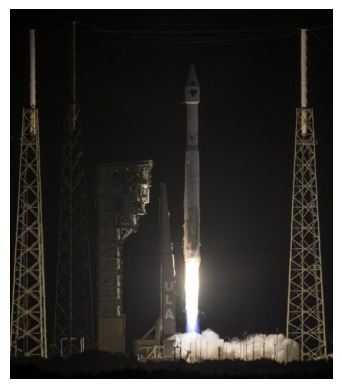

In [8]:
# search_image = './SpaceImage/A_Cauldron_of_Stars_at_the_Gal.jpg'
search_image = '../image.jpg'
#display the search image
plt.axis('off')
plt.imshow(cv2.cvtColor(cv2.imread(search_image), cv2.COLOR_BGR2RGB))
#extract features from the search image
feat_vec = feature_extract_vgg16.extractFeat(search_image)
#expand the dimension of the feature vector
feat_vec = np.expand_dims(feat_vec, axis=0)

k = 6
D, I = index_vgg.search(feat_vec, k)


/var/folders/zk/_ry6kb852zb7th8syz9wtgf00000gn/T/ipykernel_48394/4007704228.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i+1)


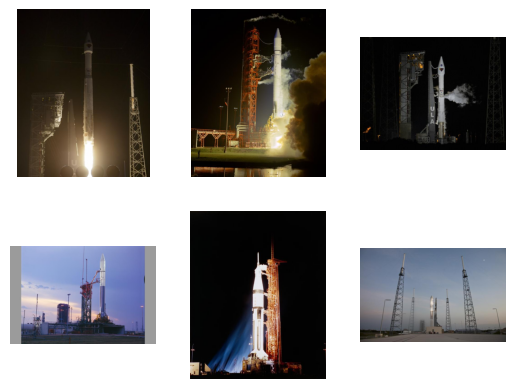

['Lucy_Spacecraft_Launch', '72PC_422', 'Lucy_Spacecraft_Prelaunch', 'ARC_1972_AC72_2139', 'Night_launch___APOLLO_7', 'KSC_2011_6241']


In [9]:
plt.imshow(cv2.cvtColor(cv2.imread(search_image), cv2.COLOR_BGR2RGB))
select_file_list = name_list_vgg[I[0]]
fig = plt.Figure(figsize=(3, 3))
image_titles = []
for i,file_name in enumerate(select_file_list):
    image_titles.append(file_name)
    # 组装文件名
    file_name = './SpaceImage/' + file_name + '.jpg'
    
    # 加载图片
    img = cv2.imread(file_name)
    # plt显示
    plt.subplot(2, 3, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()
print(image_titles)

In [10]:
print(select_file_list)

['Lucy_Spacecraft_Launch' '72PC_422' 'Lucy_Spacecraft_Prelaunch'
 'ARC_1972_AC72_2139' 'Night_launch___APOLLO_7' 'KSC_2011_6241']
